# 目的正味重量分布の予測
- pymcでチョコボールの正味重量の分布を予測する
- モデル
    - 重量分布は正規分布であると仮定する
    - 事前分布は平均28gの正規分布とする（分散を大きくして一様分布みたいなものとする）

In [1]:
import sys, os
import sqlite3
import numpy as np
import pandas as pd
import scipy.stats as stats

%matplotlib inline
import matplotlib.pyplot as plt

import pymc as pm

In [2]:
def get_data(db_file='../data/choco-ball.db', table_name='measurement', limit_code=''):
    """
    dbファイルから計測データを取得する
    
    TODO:
        エラー処理を入れる
    """
    con = sqlite3.connect(db_file)
    sql = 'SELECT '
    sql += 'measure_date,best_before,weight,box_weight,ball_number,factory,shop,angel '
    sql += ', (weight - box_weight), (weight - box_weight)/ball_number '
    sql += 'FROM ' + table_name + ' '
    sql += limit_code
    sql += ';'
    sql_result = con.execute(sql)
    res = sql_result.fetchall()
    con.close()
    data = pd.DataFrame(res, columns=['measure_date','best_before','weight','box_weight','ball_number','factory','shop','angel', 'net_weight', 'mean_weight'])
    print 'Shape of MeasurementData(record_num, n_columns) : {}'.format(data.shape)
    return data


# データをロードする
- mysqlに貯めているデータをロード
- ヒストグラムを描画してみる

Shape of MeasurementData(record_num, n_columns) : (30, 10)


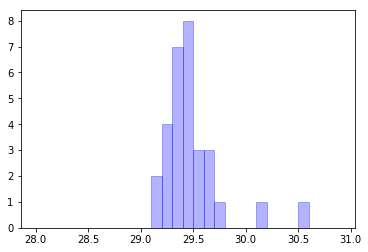

In [3]:
#data = get_data(limit_code='limit 1')
data = get_data()
ret = plt.hist(data['net_weight'], bins=np.arange(28.0, 31.0, 0.1), 
              color="#0000FF", edgecolor="#0000FF", alpha=0.3)

# 正規分布のパラメータを予測
## 最尤推定

In [4]:
m = data['net_weight'].mean()
s = data['net_weight'].std()
print 'mean:{}, std:{}'.format(m, s)

mean:29.4786, std:0.269398896652


## MCMCによるベイズ推定
### モデルの設定

In [5]:
# 精度$\tau$(分散の逆数)
tau = 1.0 / pm.Uniform("std", 0, 100)**2

# 分布の中心
## 事前分布の中心として、製品仕様の28を、tauを0.01(分散=100)
center = pm.Normal("center", 28, 0.01)

# 観測とモデルを結びつける
observations = pm.Normal("obs", center, tau, value=data['net_weight'].values, observed=True)

# Modelオブジェクト生成
model = pm.Model([tau, center])

### mcmcの計算

In [6]:
mcmc = pm.MCMC(model)
mcmc.sample(30000) # バーンイン無し

 [-----------------100%-----------------] 30000 of 30000 complete in 2.4 sec

### MCMCの結果を確認

In [7]:
center_trace = mcmc.trace("center")[:]
std_trace = mcmc.trace("std")[:]

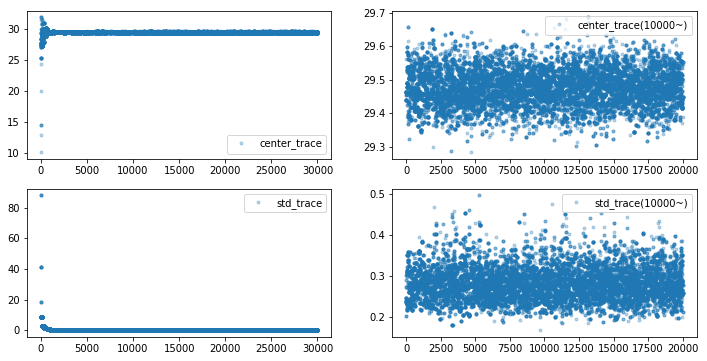

In [8]:
plt.figure(figsize=(12, 6))
plt.subplot(2,2,1)
plt.plot(center_trace, '.', alpha=0.3, label="center_trace")
plt.legend()

plt.subplot(2,2,2)
plt.plot(center_trace[10000:], '.', alpha=0.3, label="center_trace(10000~)")
plt.legend()

plt.subplot(2,2,3)
plt.plot(std_trace, '.', alpha=0.3, label="std_trace")
plt.legend()

plt.subplot(2,2,4)
plt.plot(std_trace[10000:], '.', alpha=0.3, label="std_trace(10000~)")
plt.legend()
#plt.savefig("trace_plot_net_weight.png")

上記の結果は、MCMCでのシミュレーションサンプルの系列を表している。
開始すぐに収束しているのがわかる。

esetimate_center : 29.4559763336
Bayesian credit section [5%~95%] : 29.393524647~29.5618374629
estimate_std : 0.371963951976


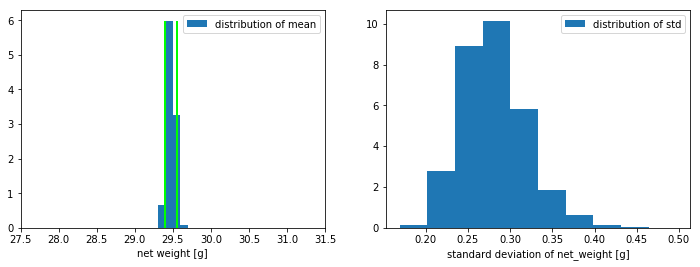

In [9]:
plt.figure(figsize=(12, 4))

# 平均の予測
plt.subplot(1,2,1)
ret = plt.hist(center_trace[10000:], bins=np.arange(28.0, 31.0, 0.1), 
               normed=True, label='distribution of mean')
# ret = plt.hist(center_trace[10000:], 
#                normed=True, label='distribution of mean')
plt.vlines(x=np.percentile(center_trace[10000:], 5), ymin=0, ymax=ret[0].max(), 
          colors='#00FF00', linewidth=2)
plt.vlines(x=np.percentile(center_trace[10000:], 95), ymin=0, ymax=ret[0].max(), 
          colors='#00FF00', linewidth=2)
plt.xlabel('net weight [g]')
plt.xlim([27.5, 31.5])
plt.legend()
print 'esetimate_center : {}'.format(center_trace[10000].mean())
print 'Bayesian credit section [5%~95%] : {}~{}'.format(
    np.percentile(center_trace[10000:], 5), np.percentile(center_trace[10000:], 95))
m_b = center_trace[10000].mean()

# 分散の予測
plt.subplot(1,2,2)
ret = plt.hist(std_trace[10000:], normed=True, label='distribution of std')
plt.xlabel('standard deviation of net_weight [g]')
plt.legend()
print 'estimate_std : {}'.format(std_trace.mean())
s_b = std_trace[10000:].mean()

plt.savefig('fig/estimated_dist_{}.png'.format(data.shape[0]))

# 予測結果を表示

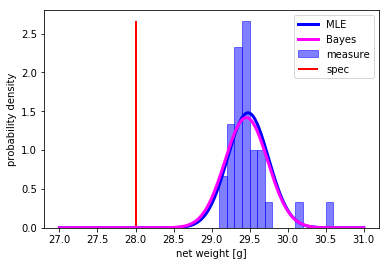

In [10]:
min_range=27.0
max_range=31.0
step=0.1
spec=28.0

b = np.arange(min_range, max_range, step)
ret = plt.hist(data['net_weight'], 
               bins=b, color="#0000FF", alpha=0.5, edgecolor="#0000FF", 
               label='measure', normed=True)
plt.vlines(x=spec, ymin=0, ymax=ret[0].max(), 
           colors='#FF0000', linewidths=2, label='spec')

# 最尤推定パラメータの分布
x = np.linspace(min_range, max_range, 300)
y = stats.norm.pdf(x, loc=m, scale=s)
plt.plot(x, y, lw=3, color='#0000FF', label='MLE')

# ベイズ推定での分布
y = stats.norm.pdf(x, loc=m_b, scale=s_b)
plt.plot(x, y, lw=3, color='#FF00FF', label='Bayes')

plt.legend()
plt.xlabel('net weight [g]')
plt.ylabel('probability density')

plt.savefig('fig/weight_distribution_{}.png'.format(data.shape[0]))